In [181]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# II La régression logistique en pratique
df = pd.read_csv("data/gold.csv")


In [182]:
from sklearn.model_selection import train_test_split
X = df.drop('Churn', axis=1)
y = df['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, shuffle=True, random_state=42)

In [183]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
y_train =  labelencoder.fit_transform(y_train)
y_test = labelencoder.transform(y_test)

In [184]:
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,nb_service_internet
0,Female,No,Yes,No,1,No,No phone service,DSL,Month-to-month,Yes,Electronic check,29.85,29.85,No,1
1,Male,No,No,No,34,Yes,No,DSL,One year,No,Mailed check,56.95,1889.50,No,2
2,Male,No,No,No,2,Yes,No,DSL,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,2
3,Male,No,No,No,45,No,No phone service,DSL,One year,No,Bank transfer (automatic),42.30,1840.75,No,3
4,Female,No,No,No,2,Yes,No,Fiber optic,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0


In [185]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 15 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   gender               7043 non-null   object 
 1   SeniorCitizen        7043 non-null   object 
 2   Partner              7043 non-null   object 
 3   Dependents           7043 non-null   object 
 4   tenure               7043 non-null   int64  
 5   PhoneService         7043 non-null   object 
 6   MultipleLines        7043 non-null   object 
 7   InternetService      7043 non-null   object 
 8   Contract             7043 non-null   object 
 9   PaperlessBilling     7043 non-null   object 
 10  PaymentMethod        7043 non-null   object 
 11  MonthlyCharges       7043 non-null   float64
 12  TotalCharges         7043 non-null   float64
 13  Churn                7043 non-null   object 
 14  nb_service_internet  7043 non-null   int64  
dtypes: float64(2), int64(2), object(11)
me

In [186]:
import numpy as np

# Convert y_train and y_test to numpy arrays
y_train = np.array(y_train)
y_test = np.array(y_test)

In [187]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn import set_config
from sklearn.preprocessing import StandardScaler

set_config(display='diagram')


categorical_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 
       'PhoneService', 'MultipleLines', 'InternetService', 'Contract', 
       'PaperlessBilling', 'PaymentMethod'
       ]

numerical_features = [
    "tenure",
    "MonthlyCharges",
    "TotalCharges",
    "nb_service_internet",
]


categorical_transformer = OneHotEncoder()

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', categorical_transformer, categorical_features),
    ],
    remainder="passthrough"
)

log_reg = LogisticRegression()

pipe = Pipeline([
     ('preprocessor', preprocessor),
     ('log_reg', log_reg)
])

In [188]:
pipe.fit(X_train, y_train)
y_pred_train = pipe.predict(X_train)
y_pred_test = pipe.predict(X_test)

lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [189]:
X_train 

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,nb_service_internet
2142,Female,No,No,Yes,21,Yes,No,DSL,One year,No,Mailed check,64.85,1336.80,3
1623,Female,No,No,No,54,Yes,Yes,Fiber optic,Two year,Yes,Bank transfer (automatic),97.20,5129.45,3
6074,Male,No,Yes,No,1,No,No phone service,DSL,Month-to-month,Yes,Electronic check,23.45,23.45,0
1362,Male,No,No,No,4,Yes,No,Fiber optic,Month-to-month,Yes,Electronic check,70.20,237.95,0
6754,Male,No,No,Yes,0,Yes,Yes,DSL,Two year,Yes,Bank transfer (automatic),61.90,0.00,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3772,Male,No,Yes,No,1,Yes,No,Fiber optic,Month-to-month,Yes,Electronic check,95.00,95.00,3
5191,Female,No,Yes,Yes,23,Yes,Yes,DSL,Two year,Yes,Credit card (automatic),91.10,2198.30,6
5226,Male,No,Yes,Yes,12,Yes,No,No,Month-to-month,Yes,Electronic check,21.15,306.05,0
5390,Male,Yes,No,No,12,Yes,Yes,Fiber optic,Month-to-month,Yes,Electronic check,99.45,1200.15,3


In [190]:
pipe.named_steps['preprocessor'].get_feature_names()

['cat__x0_Female',
 'cat__x0_Male',
 'cat__x1_No',
 'cat__x1_Yes',
 'cat__x2_No',
 'cat__x2_Yes',
 'cat__x3_No',
 'cat__x3_Yes',
 'cat__x4_No',
 'cat__x4_Yes',
 'cat__x5_No',
 'cat__x5_No phone service',
 'cat__x5_Yes',
 'cat__x6_DSL',
 'cat__x6_Fiber optic',
 'cat__x6_No',
 'cat__x7_Month-to-month',
 'cat__x7_One year',
 'cat__x7_Two year',
 'cat__x8_No',
 'cat__x8_Yes',
 'cat__x9_Bank transfer (automatic)',
 'cat__x9_Credit card (automatic)',
 'cat__x9_Electronic check',
 'cat__x9_Mailed check',
 'tenure',
 'MonthlyCharges',
 'TotalCharges',
 'nb_service_internet']

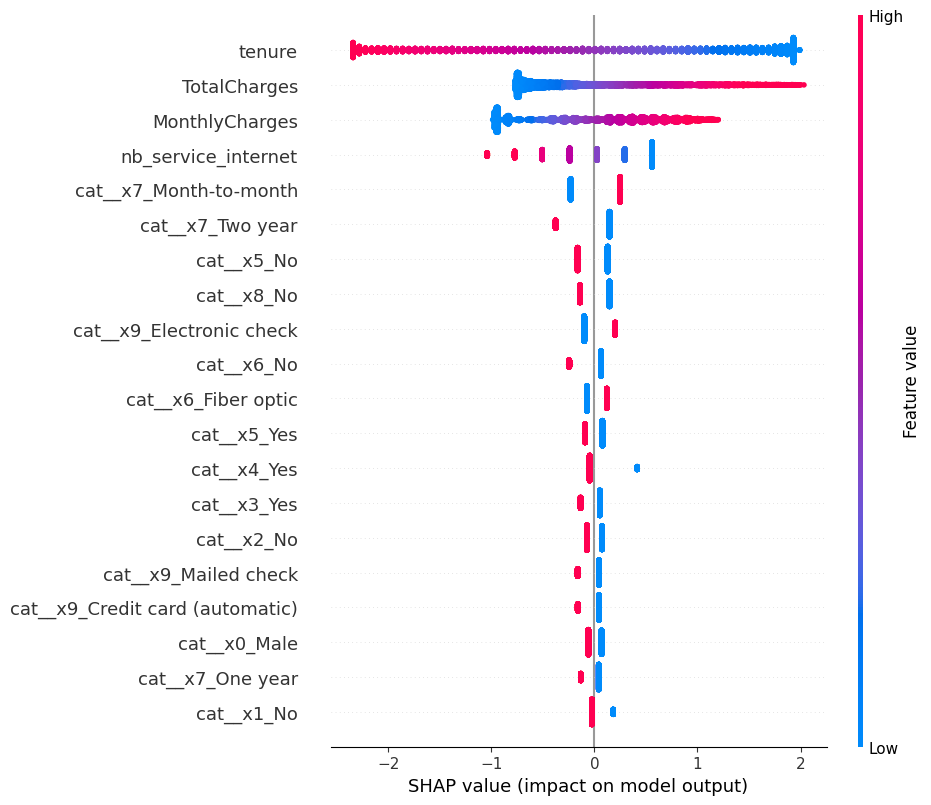

In [194]:
import shap


# Calculate SHAP values and show the most important features for a logistic regression model and a dataset
explainer = shap.LinearExplainer(pipe.named_steps['log_reg'], pipe.named_steps['preprocessor'].fit_transform(X_train))
shap_values = explainer.shap_values(pipe.named_steps['preprocessor'].fit_transform(X_train))

shap.summary_plot(shap_values, pipe.named_steps['preprocessor'].fit_transform(X_train), plot_type="dot", feature_names=pipe.named_steps['preprocessor'].get_feature_names())

100%|██████████| 50/50 [01:27<00:00,  1.75s/it]


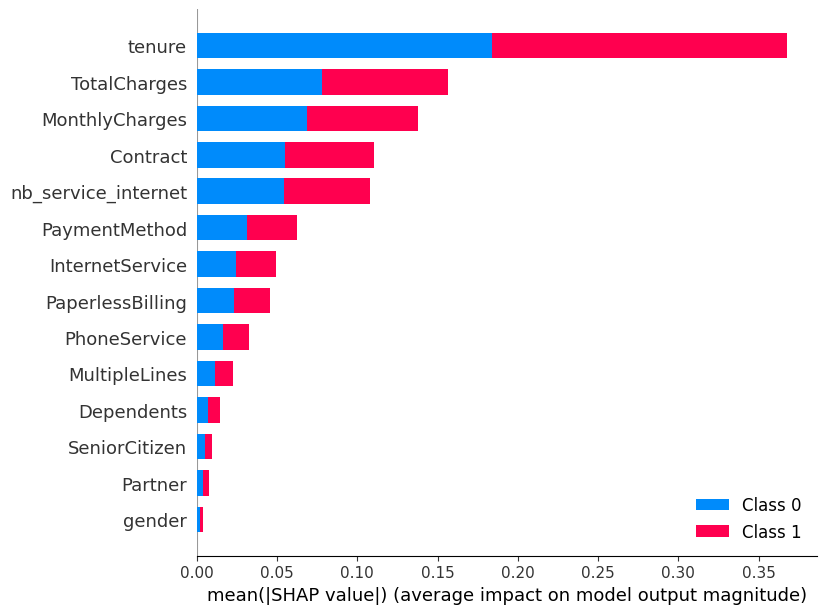

In [195]:
# Create a function to apply the pipeline's preprocessing and model prediction
def model_predict(data_asarray):
    data_asframe = pd.DataFrame(data_asarray, columns=X_train.columns)
    return pipe.predict_proba(data_asframe)

# Background dataset for the KernelExplainer
background_dataset = shap.sample(X_train, 100)  # Or use shap.kmeans(X_train, 100) for larger datasets

# Create the explainer
explainer = shap.KernelExplainer(model_predict, background_dataset)

# Calculate the SHAP values for a sample of your data
X_sample = shap.sample(X_train, 50)
shap_values = explainer.shap_values(X_sample)

# Summary plot
shap.summary_plot(shap_values, X_sample)


In [192]:
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

import numpy as np

# Convert y_pred_train and y_pred_test to numpy arrays
y_pred_train = np.array(y_pred_train)
y_pred_test = np.array(y_pred_test)

print("######## accuracy_score : ")
print("TRAIN :",accuracy_score(y_train, y_pred_train))
print("TEST :",accuracy_score(y_test, y_pred_test))

print("######## f1_score : ")
print("TRAIN :",f1_score(y_train, y_pred_train))
print("TEST :",f1_score(y_test, y_pred_test))

print("######## precision_score : ")
print("TRAIN :",precision_score(y_train, y_pred_train))
print("TEST :",precision_score(y_test, y_pred_test))

print("######## recall_score : ")    
print("TRAIN :",recall_score(y_train, y_pred_train))
print("TEST :",recall_score(y_test, y_pred_test))

######## accuracy_score : 
TRAIN : 0.8015619453319134
TEST : 0.8147622427253371
######## f1_score : 
TRAIN : 0.5928623452294245
TEST : 0.6266094420600857
######## precision_score : 
TRAIN : 0.6512
TEST : 0.6717791411042945
######## recall_score : 
TRAIN : 0.5441176470588235
TEST : 0.5871313672922251


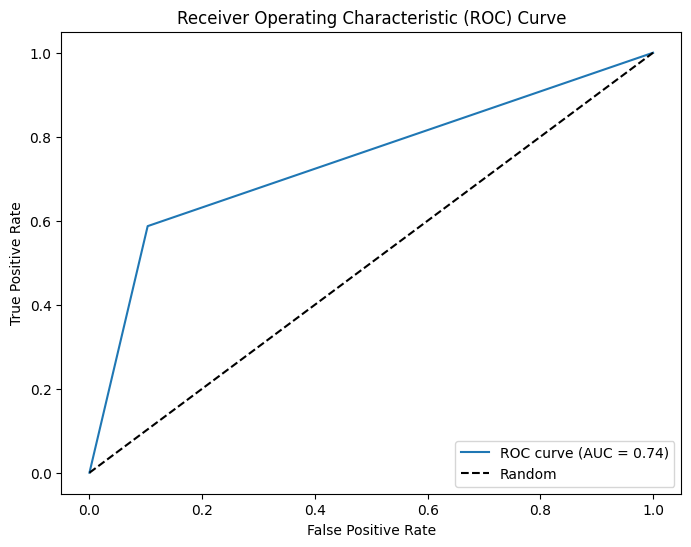

######## roc_auc_score : 
TRAIN : 0.7193763682369999
TEST : 0.741924757005186


In [193]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score


# Calculate the ROC curve
fpr, tpr, thresholds = roc_curve(y_test, y_pred_test)

# Calculate the area under the ROC curve (AUC)
auc = roc_auc_score(y_test, y_pred_test)

# Plot the ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label='ROC curve (AUC = {:.2f})'.format(auc))
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

print("######## roc_auc_score : ")    
print("TRAIN :",roc_auc_score(y_train, y_pred_train))
print("TEST :",roc_auc_score(y_test, y_pred_test))  